### __Clément Giron - Yoan Russac__

# __Compressed Sensing project : MRI and reconstruction of medical images__

#### __ENSAE ParisTech 2017/2018__

# Usefull libarires

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import random
import os
from scipy.io import loadmat
from skimage import io, color
import pywt
from numpy.linalg import svd
import time
from tqdm import tqdm

# Preliminaries

Load the image we want to rebuild.

In [2]:
# full .mat object
brain_tot = loadmat('brain.mat')
# module of the image
brain_im = np.abs(brain_tot['im'])

Visualize the brain image.

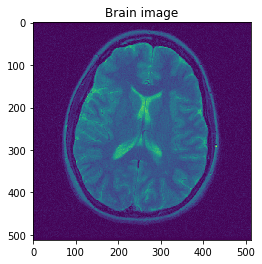

In [3]:
plt.imshow(brain_im)
plt.title('Brain image')
plt.show()

# I. Sparsity in wavelet spaces

This section does not aim at rebuilding brain images. The goal here is to show that the brain image is sparse in some wavelet space, as this fact will be re-used in the following compressed sensing algorithms. For that purpose, we transform the brain image into a wavelet space, then we operate a shrinkage on the coefficients, and try to recover the image in the pixels space.

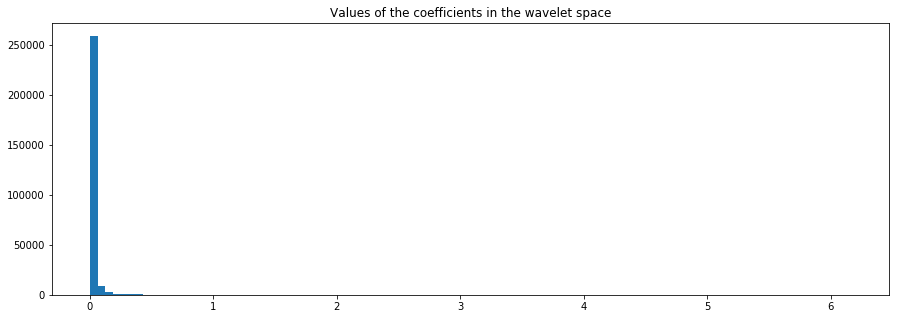

In [4]:
im_wav = pywt.wavedec2(brain_im, 'db4')
full_coef = []
for e in im_wav[1:]:
    for i in range(3):
        full_coef.append(e[1].flatten())
full_coef = np.hstack(full_coef)
plt.figure(figsize=(15,5))
plt.hist(np.abs(full_coef), range=[np.min(np.abs(full_coef)), np.max(np.abs(full_coef))], bins=100)
plt.title('Values of the coefficients in the wavelet space')
plt.show()

This shows that the image is very sparse in the wavelet space. We will operate a shrinkage and keep only the top 5% of the coefficients.

In [5]:
threshold = np.sort(np.abs(full_coef))[int(full_coef.shape[0]*0.95)]
im_shrink = [np.zeros(im_wav[0].shape)]
for i in range(1,7):
    im1 = np.multiply(im_wav[i][0], np.abs(im_wav[i][0])>threshold)
    im2 = np.multiply(im_wav[i][1], np.abs(im_wav[i][1])>threshold)
    im3 = np.multiply(im_wav[i][2], np.abs(im_wav[i][2])>threshold)
    im_shrink.append((im1, im2, im3))
im_recover = pywt.waverec2(im_shrink, 'db4')

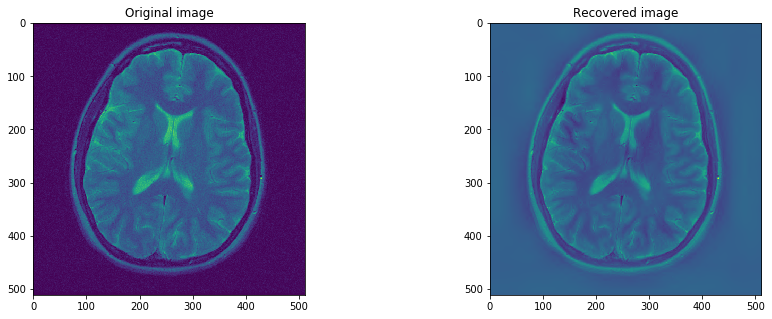

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(brain_im)
ax1.set_title('Original image')
ax2.imshow(im_recover)
ax2.set_title('Recovered image')
plt.show()

This shows the sparsity of the brain image in the Daubechies 4 wavelet space.

# II. Projection Over a Convex Set algorithm (POCS)

We will now act as if we were in MRI conditions and use compressed sensing to recover the brain image. For that purpose, we suppose that we observe only a subsample of the Fourier coefficients of the brain image (in the frequencies space).

First, we visualize the mask (i.e. the positions of the Fourier coefficients we observe) and the density from which this mask is sampled. This mask represents 33% of the total number of pixels of the image. Note that this sample contains more observation in the low frequencies (center of the image).

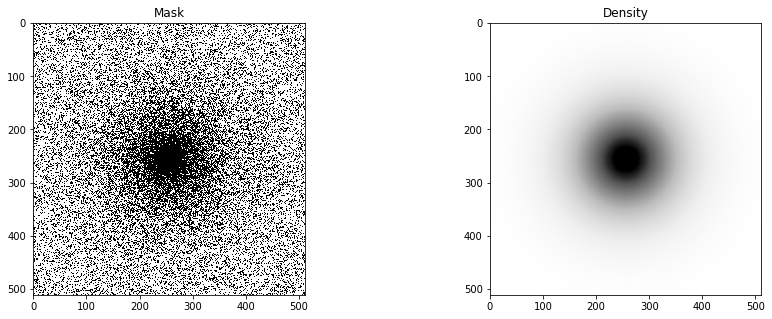

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(brain_tot['mask_vardens'], cmap= 'Greys')
ax1.set_title('Mask')
ax2.imshow(brain_tot['pdf_vardens'], cmap= 'Greys')
ax2.set_title('Density')
plt.show()

Now, let us define the function to operate a soft thresholding in the wavelet space.

In [8]:
def SoftThresholding(arr, lambda_value):
    """
    Input: - arr: a matrix
           - lambda_value: shrinkage threshold
    Output: shrinked image
    """
    n,p = arr.shape
    arr_copy = np.copy(arr)
    for i in range(n):
        for j in range(p):
            # here is the thresholding
            if np.abs(arr[i,j]) > lambda_value:
                arr_copy[i,j] = (np.abs(arr[i,j])-lambda_value)*arr[i,j]/np.abs(arr[i,j])
            else:
                arr_copy[i,j] = 0
    return(arr_copy)


def FullSoftThresholding_wavedec(l, lambda_value):
    """
    Input: - l: the wavelet coefficients of the image
           - lambda_value: shrinkage threshold
    Output: shrinked wavelet coefficients
    """
    # apply the thresholding to the full wavelet decomposition
    res = [SoftThresholding(l[0], lambda_value)]
    for e in l[1:]:
        res.append((SoftThresholding(e[0], lambda_value), SoftThresholding(e[1], lambda_value), SoftThresholding(e[2], lambda_value)))
    return res

Here is the POCS alogorithm. Its running is explained in the report.

In [9]:
def pocs(y, mask, N_iter, l):
    """
    Input: - y: measured coefficients in the Fourier space
           - mask: the mask of the measured coefficients
           - N_iter: number of iterations
           - l: threshold value
    Output: list of rebuild images (at each iteration)
    """
    im_cs = np.fft.ifft2(np.multiply(y, 1))
    #im_cs = np.fft.ifft2(np.multiply(DATA,1/brain_tot['pdf_vardens']))

    l_res = [im_cs]
    for i in tqdm(range(N_iter)):
        
        # wavelets + thresholding
        wavelet_im = pywt.wavedec2(im_cs, 'db4')
        im_cs = pywt.waverec2(FullSoftThresholding_wavedec(wavelet_im, l), 'db4')
        
        # projection
        im_cs = np.abs(np.fft.ifft2(np.multiply(np.fft.fft2(im_cs),1-mask) + y))
        
        # append result
        l_res.append(np.abs(im_cs))
    
    return l_res

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.94it/s]


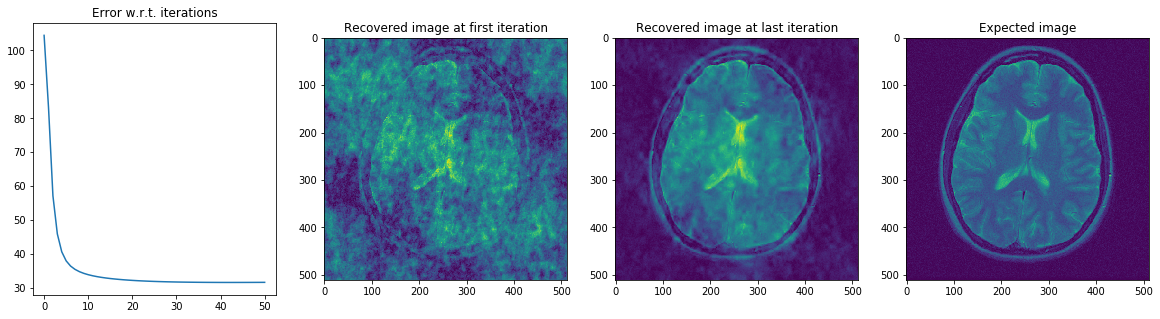

In [11]:
# measured coefficients in the k-space
y = np.multiply(np.fft.fft2(brain_im), brain_tot['mask_vardens'])
# other parameters
mask = brain_tot['mask_vardens']
N_iter = 50
l = 0.025
# algorithm
hist = pocs(y, mask, N_iter, l)

# plots
errors = [np.linalg.norm(brain_im-e) for e in hist]
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.plot(errors)
ax1.set_title('Error w.r.t. iterations')
ax2.imshow(np.abs(hist[0]))
ax2.set_title('Recovered image at first iteration')
ax3.imshow(np.abs(hist[-1]))
ax3.set_title('Recovered image at last iteration')
ax4.imshow(brain_im)
ax4.set_title('Expected image')
plt.show()

The results seem fair, but clearly not as good as those presented in the research papers.

# III. Non-linear Conjugate-Gradient algorithm

Here is the implementation of the algorithm proposed by Lustig et al. in "Sparse MRI: The Application of Compressed Sensing for Rapid MR Imaging".

In [12]:
def objective_function(m, y, l, mask):
    """
    Input: - m: image
           - y: measured coefficients in the Fourier space
           - l: penalty parameter
           - mask: the mask of the measured coefficients
    Output: objective function value
    """
    wm = pywt.wavedec2(m, 'db4')
    l1norm = np.sum(np.abs(wm[0]))
    for e in wm[1:]:
        for i in range(3):
            l1norm += np.sum(np.abs(e[i]))
    return np.linalg.norm(np.multiply(np.fft.fft2(m), mask) - y)**2 + l*l1norm


def grad_objectif_function(m, y, l, mask, mu):
    """
    Input: - m: image
           - y: measured coefficients in the Fourier space
           - l: penalty parameter
           - mask: the mask of the measured coefficients
           - mu: approximation parameter
    Output: gradient of the objective function 
    """
    wm = pywt.wavedec2(m, 'db4')
    wm[0] = np.multiply(1/np.sqrt(wm[0]**2+mu), wm[0])
    for i in range(1,7):
        detail_list = []
        for j in range(3):
            detail_list.append(np.multiply(1/np.sqrt(wm[i][j]**2+mu), wm[i][j]))
        wm[i] = tuple(detail_list)
    return 2*np.fft.ifft2(np.multiply(np.fft.fft2(m), mask) - y) + l*pywt.waverec2(wm, 'db4')


def iterative_reconstruction(y, mask, l, max_iter, mu, alpha=0.05, beta=0.6):
    """
    Input: - y: measured coefficients in the Fourier space
           - l: penalty parameter
           - mask: the mask of the measured coefficients
           - max_iter: number of iterations
           - mu: approximation parameter
           - alpha, beta: backtracking line-search parameters
    Output: gradient of the objective function 
    """
    m = np.zeros(y.shape)
    m_list = []
    g = grad_objectif_function(m, y, l, mask, mu)
    delta_m = -g
    for k in tqdm(range(max_iter)):
        
        # backtracking line-search
        t = 1
        obj_m = objective_function(m, y, l, mask)
        while objective_function(m + t*delta_m, y, l, mask) > obj_m + alpha*t*np.real(np.sum(np.multiply(np.transpose(np.conjugate(g)), delta_m))):
            t = beta*t
        
        # step
        m = m + t*delta_m
        m = np.abs(m)
        
        # update gradients and momentum
        g_1 = g.copy()
        g = grad_objectif_function(m, y, l, mask, mu)
        gamma = (np.linalg.norm(g)/np.linalg.norm(g_1))**2
        delta_m = -g + gamma*delta_m
        
        # append result
        m_list.append(m)
        
    return m_list

Test it on the same example as before.

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.31it/s]


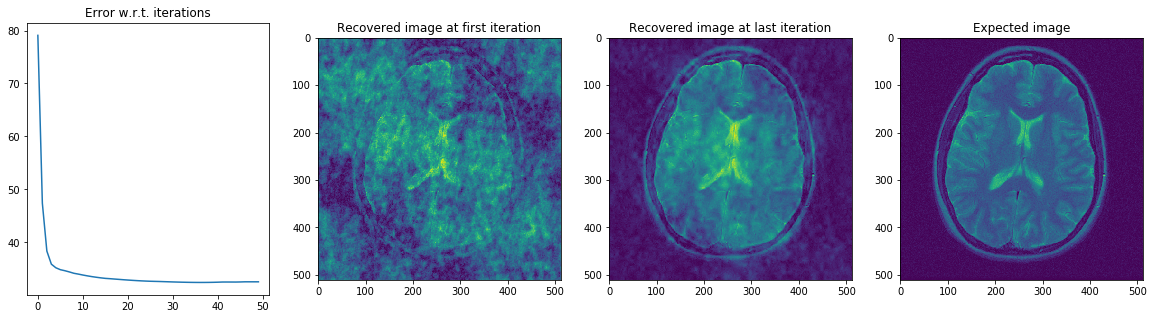

In [13]:
y = np.multiply(np.fft.fft2(brain_im), brain_tot['mask_vardens'])
mask = brain_tot['mask_vardens']
max_iter = 50
l = 0.01
mu = 1e-15
hist = iterative_reconstruction(y, mask, l, max_iter, mu, alpha=0.05, beta=0.6)
errors = [np.linalg.norm(brain_im-e) for e in hist]
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.plot(errors)
ax1.set_title('Error w.r.t. iterations')
ax2.imshow(np.abs(hist[0]))
ax2.set_title('Recovered image at first iteration')
ax3.imshow(np.abs(hist[-1]))
ax3.set_title('Recovered image at last iteration')
ax4.imshow(brain_im)
ax4.set_title('Expected image')
plt.show()

The results are somehow similar to those obtained using the POCS algorithm.

# IV. Importance of the sampling

In the report, we explained how important is the sampling of the mesured points in the k-space. In this section, we will show it using a uniform mask, instead of the previous mask where low frequencies where more sampled than high frequencies.

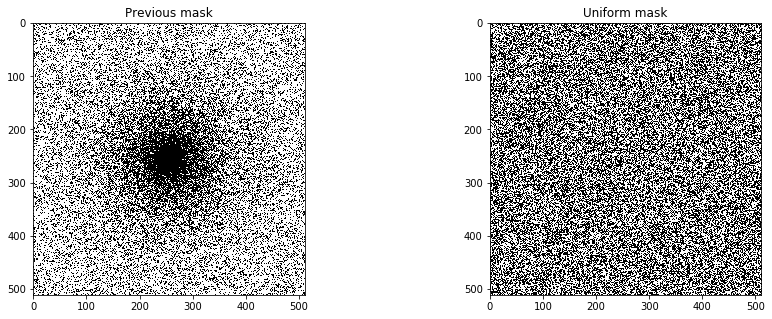

In [14]:
p = 0.5
mask_uniform = np.random.binomial(1, p, brain_im.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(brain_tot['mask_vardens'], cmap= 'Greys')
ax1.set_title('Previous mask')
ax2.imshow(mask_uniform, cmap= 'Greys')
ax2.set_title('Uniform mask')
plt.show()

Let us now apply the POCS algorithm.

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.81it/s]


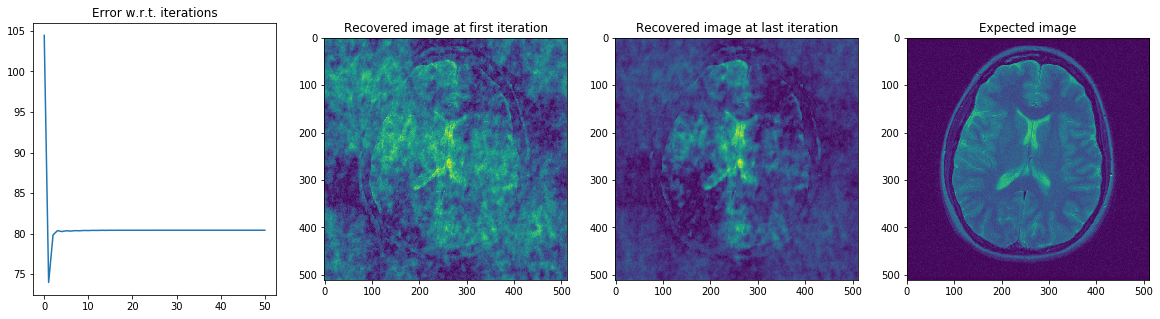

In [19]:
y = np.multiply(np.fft.fft2(brain_im), brain_tot['mask_vardens'])
mask = mask_uniform
N_iter = 50
l = 0.025
hist = pocs(y, mask, N_iter, l)
errors = [np.linalg.norm(brain_im-e) for e in hist]
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.plot(errors)
ax1.set_title('Error w.r.t. iterations')
ax2.imshow(np.abs(hist[0]))
ax2.set_title('Recovered image at first iteration')
ax3.imshow(np.abs(hist[-1]))
ax3.set_title('Recovered image at last iteration')
ax4.imshow(brain_im)
ax4.set_title('Expected image')
plt.show()

The mask contains more measures than in the previous part, but the results are clearly poorer. We will now test the gradient-conjugate algorithm.

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.84it/s]


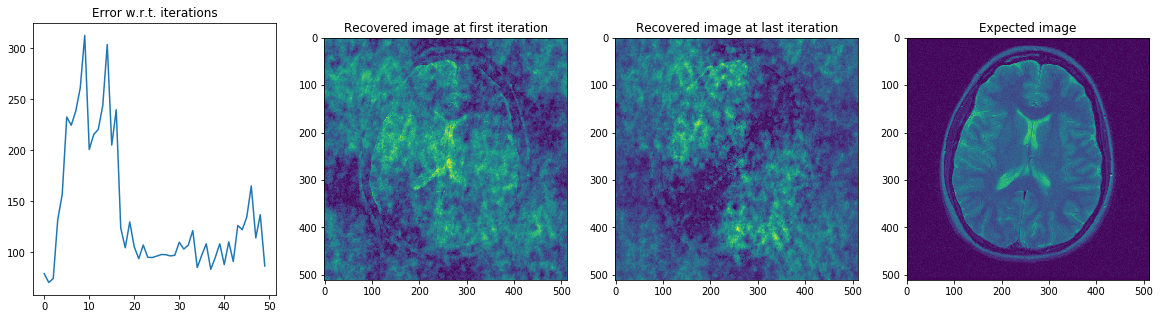

In [20]:
y = np.multiply(np.fft.fft2(brain_im), brain_tot['mask_vardens'])
mask = mask_uniform
max_iter = 50
l = 0.01
mu = 1e-15
hist = iterative_reconstruction(y, mask, l, max_iter, mu, alpha=0.05, beta=0.6)
errors = [np.linalg.norm(brain_im-e) for e in hist]
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.plot(errors)
ax1.set_title('Error w.r.t. iterations')
ax2.imshow(np.abs(hist[0]))
ax2.set_title('Recovered image at first iteration')
ax3.imshow(np.abs(hist[-1]))
ax3.set_title('Recovered image at last iteration')
ax4.imshow(brain_im)
ax4.set_title('Expected image')
plt.show()

Same as for the POCS algorithm: the results are poorer than before, due to the inefficient sampling of the measured points in the k-space.